In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq
import nichepca as npc
import torch

from src.utilities import *

from collections import Counter
import random
from tqdm import tqdm 

device = "cpu"
torch.set_num_threads(100)

seed = 200
torch.manual_seed(seed)

/home/byousefi/envs/nichepca/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_path = "data/"
# data_path = "/data/projects/robin/segmentation/xenium_outs/merged_processed_before_integration.h5ad"
data_path = "/data/projects/robin/segmentation/xenium_outs/merged_processed_cleaned.h5ad"

In [3]:
# Read data
adata = sc.read_h5ad(data_path)

In [4]:
slide_set = adata.obs['Slide_ID'].unique()
slide_set

['0011695', '0018775', '0011707', '0011287', '0011762', '0011284', '0011546', '0011216']
Categories (8, object): ['0011216', '0011284', '0011287', '0011546', '0011695', '0011707', '0011762', '0018775']

In [5]:
# run domain pca
slide = 8
adata_slide = adata[adata.obs['Slide_ID'] == slide_set[slide]]

npc.wf.run_nichepca(adata_slide, 
                    knn=5,
                    radius=None,
                    sample_key="Patient_Sample_ID", 
                    n_comps=30,
                    norm_per_sample = False,)

IndexError: index 8 is out of bounds for axis 0 with size 8

In [ ]:
sample_set = adata_slide.obs['Patient_Sample_ID'].unique()

In [ ]:
sc.pl.pca(
    adata_slide,
    color="Patient_Sample_ID",
    wspace=0.4,
)

In [ ]:
adata

In [ ]:
# Clustering with leiden in the embedding space using diffrent resolutions
resolutions = [.1, .2, .3]
sc.pp.neighbors(adata_slide, use_rep="X_pca_harmony")
adata_slide, _ = multiple_lediden(adata_slide, resolutions, key_added='leiden_pcah', n_jobs=20, verbos=False)
sc.pp.neighbors(adata_slide, use_rep="X_pca")
adata_slide, _ = multiple_lediden(adata_slide, resolutions, key_added='leiden_pca', n_jobs=20, verbos=False)

In [ ]:
adata_slide.obs

In [ ]:
resolution_best = .1
choose = 0

sc.pl.pca(
    adata_slide,
    color=[
        "leiden_pcah_res_"+str(resolution_best),
        "leiden_pca_res_"+str(resolution_best)
    ][choose],
    wspace=0.4,
)

In [ ]:
# adata_i.uns.pop(f'leiden_{resolution_best}_colors');
sample = sample_set[5]
resolution_best = .2
choose = 1

fig, ax = plt.subplots(figsize=(8, 8))

sq.pl.spatial_scatter(
    adata_slide[adata_slide.obs['Patient_Sample_ID'] == sample],
    library_id="spatial",
    shape=None,
    color=[
        "leiden_pcah_res_"+str(resolution_best),
        "leiden_pca_res_"+str(resolution_best)
    ][choose],
    wspace=0.1,
    ax = ax
)

In [13]:
adata_slide.obs['is_glom'] = '0'
adata_slide.obs.loc[adata_slide.obs['leiden_pca_res_0.2'] == '6', 'is_glom'] = '1'

/home/byousefi/envs/nichepca/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/byousefi/envs/nichepca/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


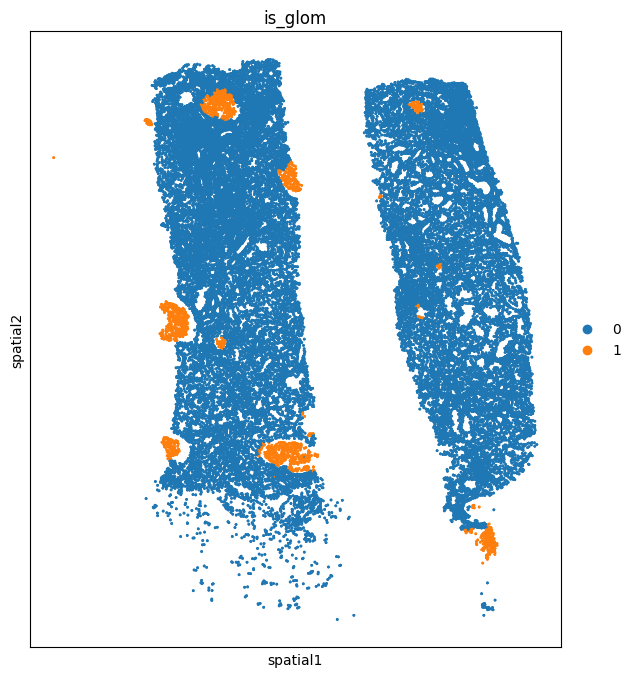

In [14]:
# adata_i.uns.pop(f'leiden_{resolution_best}_colors');
sample = sample_set[3]

fig, ax = plt.subplots(figsize=(8, 8))
sq.pl.spatial_scatter(
    adata_slide[adata_slide.obs['Patient_Sample_ID'] == sample],
    library_id="spatial",
    shape=None,
    color='is_glom',
    wspace=0.1,
    ax = ax
)

In [15]:
adata_slide.write(f"data/adata_nichepca_slide_{slide_set[slide]}_clustered.h5ad")
f"data/adata_nichepca_slide_{slide_set[slide]}_clustered.h5ad"

'data/adata_nichepca_slide_0011762_clustered.h5ad'

In [16]:
f"data/adata_nichepca_slide_{slide_set[slide]}_clustered.h5ad"

'data/adata_nichepca_slide_0011762_clustered.h5ad'